In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import bilby
import corner
import numpy as np

# this is how the priors would work

In [3]:
def mass_sample(num_samples, bounds = [10,80]):
    scale = bounds[1] - bounds[0]
    unif_1 = tfp.distributions.Uniform(0,1)
    m1 = tf.sqrt(unif_1.sample(num_samples))
    
    unif_2 = tfp.distributions.Uniform(0,m1)
    m2 = unif_2.sample()
    return tf.concat([[m1*scale + bounds[0]],[m2*scale + bounds[0]]], axis = 0)

In [4]:
def mass_post(m1,m2, bounds):
    output = tf.ones(len(m1))/((bounds[1] - bounds[0])**2)
    mass_mask = tf.greater(m2, m1) | tf.less(m1, bounds[0]) | tf.less(m2, bounds[0]) | tf.greater(m1, bounds[1]) | tf.greater(m2, bounds[1])
    infs =  tf.multiply(tf.ones_like(output), tf.constant(-np.inf, dtype=tf.float32))
    output = tf.where(mass_mask, infs, output)
    return output

In [6]:
def mass_throw_away(num_samples, bounds = [10,80]):
    scale = bounds[1] - bounds[0]
    unif_1 = tfp.distributions.Uniform(0,1)
    unif_2 = tfp.distributions.Uniform(0,1)
    samples = []
    for i in range(num_samples):
        m2 = unif_1.sample()
        m1 = unif_2.sample()
        while m1 < m2:
            m2 = unif_1.sample()
            m1 = unif_2.sample()
        
        samples.append([m1*scale + bounds[0],m2*scale + bounds[0]])
    return samples

In [7]:
masses = mass_sample(15000).numpy()

In [8]:
masses2 = mass_throw_away(5000)

In [9]:
bilby_prior = bilby.gw.prior.BBHPriorDict()

03:01 bilby INFO    : No prior given, using default BBH priors in /home/joseph.bayley/.local/lib/python3.7/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [10]:
bilby_prior = bilby.gw.prior.BBHPriorDict()
bilby_prior['mass_ratio'] = bilby.gw.prior.Constraint(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None)
bilby_prior['chirp_mass'] = bilby.gw.prior.Constraint(minimum=10, maximum=100, name='chirp_mass', latex_label='$q$', unit=None)
bilby_prior['mass_1'] = bilby.gw.prior.Uniform(name='mass_1', minimum=10, maximum=80,unit='$M_{\odot}$')
bilby_prior['mass_2'] = bilby.gw.prior.Uniform(name='mass_2', minimum=10, maximum=80,unit='$M_{\odot}$')

In [18]:
bilby_prior.keys()

dict_keys(['mass_1', 'mass_2', 'mass_ratio', 'chirp_mass', 'luminosity_distance', 'dec', 'ra', 'theta_jn', 'psi', 'phase', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl'])

In [11]:
bilby_samp = bilby_prior.sample(15000)

In [14]:
bilby_masses = np.array([bilby_samp["mass_1"], bilby_samp["mass_2"]]).T

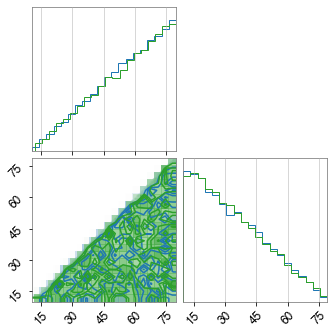

In [15]:
fig1 = corner.corner(masses.T, color = "C0")
#fig1 = corner.corner(np.array(masses2), fig=fig1, color = "C1")
fig1 = corner.corner(bilby_masses, fig=fig1, color = "C2")

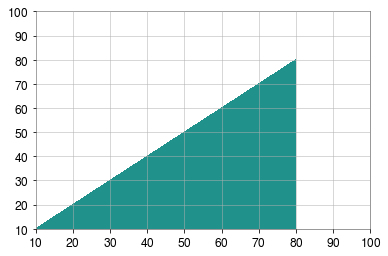

In [258]:
fig, ax = plt.subplots()
x = np.linspace(10,100,100)
X,Y = np.meshgrid(x,x)
theo_post = mass_post(X.ravel(),Y.ravel(), bounds = [10,80]).numpy()
ax.contourf(X, Y, theo_post.reshape(len(x), len(x)))

In [20]:
bilby_mass_ratios = np.array([bilby_samp["mass_1"]/bilby_samp["mass_2"], bilby_samp["mass_1"] + bilby_samp["mass_2"]]).T

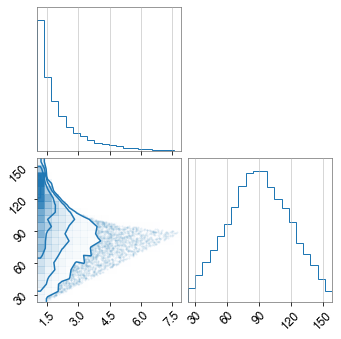

In [22]:
fig1 = corner.corner(bilby_mass_ratios, color = "C0")

# for output posteriors

In [35]:
mean_mass_r2 = tf.cast(tf.expand_dims(tf.linspace([0,0],[1,1],1000, axis = 1), 0), dtype=tf.float32)
logvar_mass_r2 = tf.cast(tf.expand_dims(tf.linspace([-10,-10],[0,0],1000, axis = 1), 0), dtype=tf.float32)
m1,m2 = tf.split(mean_mass_r2, 2, axis = 1)
lv1,lv2 = tf.split(logvar_mass_r2, 2, axis = 1)

In [ ]:
class Truncated_2D():
    
    def __init__(self, mean, var, a , b):
        
        
        
        self._big_phi_a = self._big_phi(self.a)
        self._big_phi_b = self._big_phi(self.b)
        self._Z = (self._big_phi_b - self._big_phi_a).clamp_min(eps)

In [288]:
bounds = [0,1]

In [24]:
def trunc_gauss_conditional(m1, lv1, m2, lv2, p1, p2):
    tmvn_mass1_r2 = tfp.distributions.TruncatedNormal(
                    loc=tf.cast(m1,dtype=tf.float32),
                    scale=tf.cast(tf.sqrt(tf.exp(lv1)),dtype=tf.float32),
                    low=-10.0 + 1*10.0, high=1.0 + 10.0 - 1*10.0)

    tmvn_mass2_r2 = tfp.distributions.TruncatedNormal(
                    loc=tf.cast(m2,dtype=tf.float32),
                    scale=tf.cast(tf.sqrt(tf.exp(lv2)),dtype=tf.float32),
                    low=-10.0 + 1*10.0, high=p1 + 10.0 - 1*10.0)
    
    return tmvn_mass1_r2.log_prob(p1) + tmvn_mass2_r2.log_prob(p2)

In [9]:
m1,m2 = tf.split(mean_mass_r2, 2, axis = 1)

In [289]:
mass_mask = tf.greater(m2, m1) | tf.less(m1, bounds[0]) | tf.less(m2, bounds[0]) | tf.greater(m1, bounds[1]) | tf.greater(m2, bounds[1])

In [301]:
mass_log_prob = tmvn_mass_r2.log_prob(mean_mass_r2) + tf.constant(np.log(2),dtype=tf.float32)

In [302]:
mass_log_prob = tf.where(mass_log_prob, infs, output)

<tf.Tensor: shape=(1, 2, 10), dtype=float32, numpy=
array([[[5.4673557 , 4.218653  , 3.6630974 , 3.107542  ,
         2.5519862 , 1.9964517 , 1.4806607 , 1.1849303 ,
         0.99118596, 0.84907097],
        [5.4673557 , 4.218653  , 3.6630974 , 3.107542  ,
         2.5519862 , 1.9964517 , 1.4806607 , 1.1849303 ,
         0.99118596, 0.849071  ]]], dtype=float32)>

In [28]:
out_prob = trunc_gauss_conditional(mean_mass_r2, logvar_mass_r2, mean_mass_r2, logvar_mass_r2, mean_mass_r2, mean_mass_r2)

ValueError: x and y can be no greater than 2D, but have shapes (1,) and (1, 2, 10)

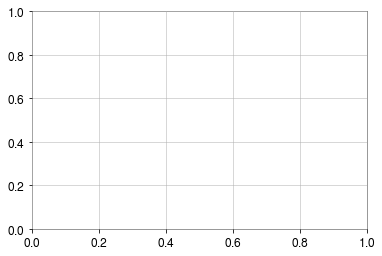

In [29]:
fig, ax = plt.subplots()
ax.plot(out_prob)

In [31]:
mean_mass_r2 = tf.cast(tf.expand_dims(tf.linspace([0.9,0.9],[0.9,0.9],1000, axis = 1), 0), dtype=tf.float32)
logvar_mass_r2 = tf.cast(tf.expand_dims(tf.linspace([-1,-10],[0,0],1000, axis = 1), 0), dtype=tf.float32)
m1,m2 = tf.split(mean_mass_r2, 2, axis = 1)
lv1,lv2 = tf.split(logvar_mass_r2, 2, axis = 1)

In [36]:
tmvn_mass1_r2 = tfp.distributions.TruncatedNormal(
                    loc=tf.cast(mean_mass_r2,dtype=tf.float32),
                    scale=tf.cast(tf.sqrt(tf.exp(logvar_mass_r2)),dtype=tf.float32),
                    low=-10.0 + 1*10.0, high=1.0 + 10.0 - 1*10.0)

In [37]:
tmvn_mass1_r2.sample()

<tf.Tensor: shape=(1, 2, 1000), dtype=float32, numpy=
array([[[0.60668707, 0.5341557 , 0.6957475 , ..., 0.8488993 ,
         0.92496574, 0.61471   ],
        [0.8925711 , 0.903577  , 0.9002244 , ..., 0.2401663 ,
         0.57586026, 0.795757  ]]], dtype=float32)>

In [32]:
Root = tfp.distributions.JointDistributionCoroutine.Root 
def model():
    md1 = yield Root(tfp.distributions.TruncatedNormal(
                    loc=tf.cast(m1,dtype=tf.float32),
                    scale=tf.cast(tf.sqrt(tf.exp(lv1)),dtype=tf.float32),
                    low=0, high=1))

    md2 = yield tfp.distributions.TruncatedNormal(
                    loc=tf.cast(m2,dtype=tf.float32),
                    scale=tf.cast(tf.sqrt(tf.exp(lv2)),dtype=tf.float32),
                    low=0, high=md1)


In [33]:
joint = tfp.distributions.JointDistributionCoroutine(model)


In [34]:
x = joint.sample()

In [35]:
joint.log_prob(m1,m2)

<tf.Tensor: shape=(1, 1, 1000), dtype=float32, numpy=
array([[[5.0553346 , 5.050093  , 5.0448513 , ..., 0.3504637 ,
         0.34912837, 0.3478037 ]]], dtype=float32)>

In [41]:
tf.concat(x, axis = 1)

<tf.Tensor: shape=(1, 2, 1000), dtype=float32, numpy=
array([[[0.42983392, 0.48689687, 0.9270321 , ..., 0.43221748,
         0.49315047, 0.2825325 ],
        [0.4295839 , 0.4868681 , 0.8973866 , ..., 0.16268986,
         0.19988918, 0.2310242 ]]], dtype=float32)>

In [109]:
np.shape(np.array(x)[:,0,0,:])

(2, 1000)

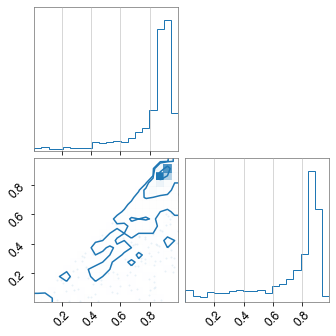

In [110]:
fig1 = corner.corner(np.array(x)[:,0,0,:].T, color = "C0")

# Trianguler distribution sampling

In [3]:
un = tfp.distributions.Uniform(0,1)

use the cdf of a triangle distribution (between 0 and 1)
PDF:
\begin{equation}
f(x) = 2x
\end{equation}
CDF:
\begin{equation}
F(x) = x^2
\end{equation}

In [4]:
smps = tf.sqrt(un.sample(5000).numpy())

(array([  57.,  157.,  266.,  329.,  443.,  551.,  610.,  718.,
         852., 1017.]),
 array([0.00269662, 0.10241976, 0.2021429 , 0.30186602,
        0.40158918, 0.5013123 , 0.6010355 , 0.7007586 ,
        0.80048174, 0.90020484, 0.999928  ], dtype=float32),
 <BarContainer object of 10 artists>)

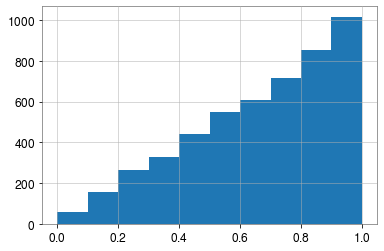

In [5]:
fig, ax = plt.subplots()
ax.hist(smps)

# mass ratio and chirp mass

In [1]:
def m1m2_to_chirpmassq(m1,m2):
    chirp_mass = ((m1*m2)**(3./5))/((m1 + m2)**(1./5))
    q = m2/m1
    return chirp_mass, q

def chirpmassq_to_m1m2(chirp_mass, q):
    m1 = chirp_mass*((1+q)/(q**3))**(1./5)
    m2 = m1*q
    return m1,m2

In [23]:
bilby_prior = bilby.gw.prior.BBHPriorDict()
bilby_prior['mass_ratio'] = bilby.gw.prior.Constraint(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None)
bilby_prior['chirp_mass'] = bilby.gw.prior.Constraint(minimum=10, maximum=100, name='chirp_mass', latex_label='$q$', unit=None)
bilby_prior['mass_1'] = bilby.gw.prior.Uniform(name='mass_1', minimum=10, maximum=100,unit='$M_{\odot}$')
bilby_prior['mass_2'] = bilby.gw.prior.Uniform(name='mass_2', minimum=10, maximum=100,unit='$M_{\odot}$')

01:43 bilby INFO    : No prior given, using default BBH priors in /home/joseph.bayley/.local/lib/python3.7/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [24]:
bilby_samp = bilby_prior.sample(10000)

In [25]:
bilby_masses = np.array([bilby_samp["mass_1"], bilby_samp["mass_2"]]).T

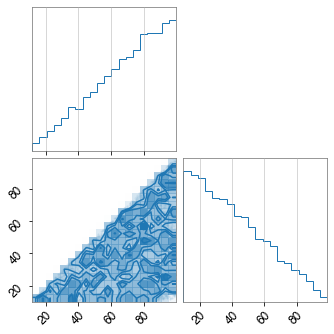

In [26]:
fig1 = corner.corner(bilby_masses, color = "C0")

In [31]:
bilby_mass_ratios = np.array(m1m2_to_chirpmassq(bilby_samp["mass_1"], bilby_samp["mass_2"])).T

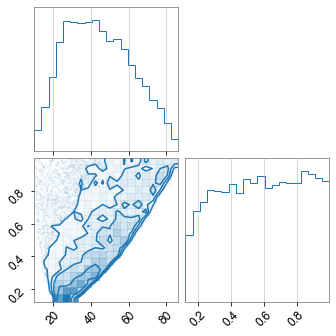

In [32]:
fig1 = corner.corner(bilby_mass_ratios, color = "C0")

In [33]:
bilby_prior2 = bilby.gw.prior.BBHPriorDict()
bilby_prior2['mass_ratio'] = bilby.gw.prior.Constraint(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None)
bilby_prior2['chirp_mass'] = bilby.gw.prior.Constraint(minimum=10, maximum=100, name='chirp_mass', latex_label='$q$', unit=None)
bilby_prior2['mass_1'] = bilby.gw.prior.Uniform(name='mass_1', minimum=10, maximum=35,unit='$M_{\odot}$')
bilby_prior2['mass_2'] = bilby.gw.prior.Uniform(name='mass_2', minimum=10, maximum=35,unit='$M_{\odot}$')

01:45 bilby INFO    : No prior given, using default BBH priors in /home/joseph.bayley/.local/lib/python3.7/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [35]:
bilby_samp2 = bilby_prior2.sample(10000)
bilby_masses2 = np.array([bilby_samp2["mass_1"], bilby_samp2["mass_2"]]).T
bilby_mass_ratios2 = np.array(m1m2_to_chirpmassq(bilby_samp2["mass_1"], bilby_samp2["mass_2"])).T

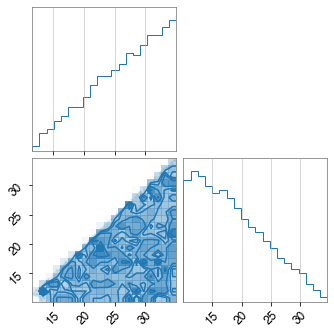

In [38]:
fig2 = corner.corner(bilby_masses2, color = "C0")

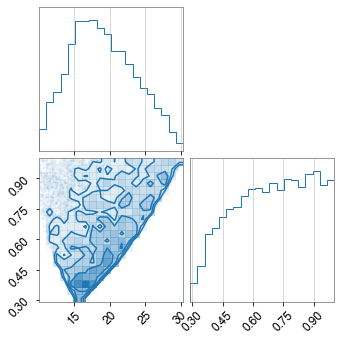

In [37]:
fig2r = corner.corner(bilby_mass_ratios2, color = "C0")

In [39]:
bilby_prior3 = bilby.gw.prior.BBHPriorDict()
bilby_prior3['mass_ratio'] = bilby.gw.prior.Constraint(minimum=0.125, maximum=0.4, name='mass_ratio', latex_label='$q$', unit=None)
bilby_prior3['chirp_mass'] = bilby.gw.prior.Constraint(minimum=10, maximum=100, name='chirp_mass', latex_label='$q$', unit=None)
bilby_prior3['mass_1'] = bilby.gw.prior.Uniform(name='mass_1', minimum=10, maximum=100,unit='$M_{\odot}$')
bilby_prior3['mass_2'] = bilby.gw.prior.Uniform(name='mass_2', minimum=10, maximum=100,unit='$M_{\odot}$')

01:47 bilby INFO    : No prior given, using default BBH priors in /home/joseph.bayley/.local/lib/python3.7/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [40]:
bilby_samp3 = bilby_prior3.sample(10000)
bilby_masses3 = np.array([bilby_samp3["mass_1"], bilby_samp3["mass_2"]]).T
bilby_mass_ratios3 = np.array(m1m2_to_chirpmassq(bilby_samp3["mass_1"], bilby_samp3["mass_2"])).T

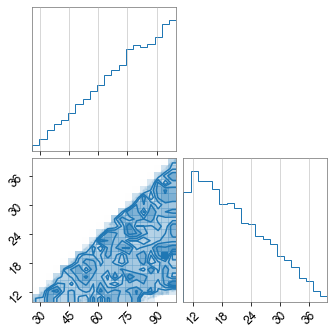

In [41]:
fig3 = corner.corner(bilby_masses3, color = "C0")

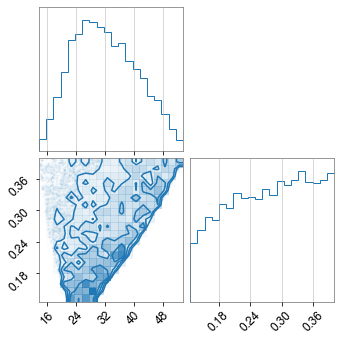

In [42]:
fig3r = corner.corner(bilby_mass_ratios3, color = "C0")

In [47]:
bilby_prior4 = bilby.gw.prior.BBHPriorDict()
bilby_prior4['mass_ratio'] = bilby.gw.prior.Constraint(minimum=0.125, maximum=1.0, name='mass_ratio', latex_label='$q$', unit=None)
bilby_prior4['chirp_mass'] = bilby.gw.prior.Constraint(minimum=10, maximum=100, name='chirp_mass', latex_label='$q$', unit=None)
bilby_prior4['mass_1'] = bilby.gw.prior.Uniform(name='mass_1', minimum=35, maximum=80,unit='$M_{\odot}$')
bilby_prior4['mass_2'] = bilby.gw.prior.Uniform(name='mass_2', minimum=35, maximum=80,unit='$M_{\odot}$')

01:50 bilby INFO    : No prior given, using default BBH priors in /home/joseph.bayley/.local/lib/python3.7/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [48]:
bilby_samp4 = bilby_prior4.sample(10000)
bilby_masses4 = np.array([bilby_samp4["mass_1"], bilby_samp4["mass_2"]]).T
bilby_mass_ratios4 = np.array(m1m2_to_chirpmassq(bilby_samp4["mass_1"], bilby_samp4["mass_2"])).T

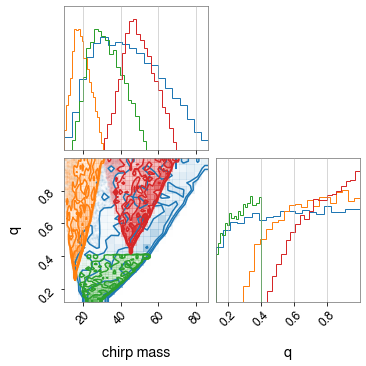

In [56]:
figmr = corner.corner(bilby_mass_ratios, color = "C0", labels = ["chirp mass", "q"])
figmr = corner.corner(bilby_mass_ratios2, color = "C1", fig = figmr)
figmr = corner.corner(bilby_mass_ratios3, color = "C2", fig = figmr)
figmr = corner.corner(bilby_mass_ratios4, color = "C3", fig = figmr)

In [57]:
figmr.savefig("./massratios.png")